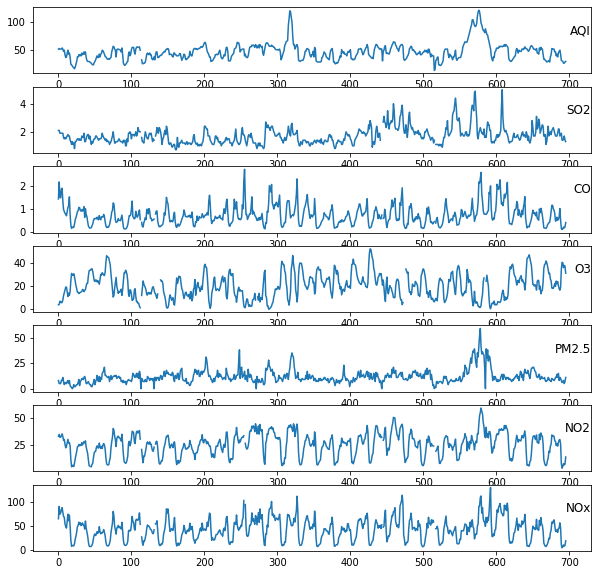

[ 17.  13.  10.  16.  20.  18.  18.  17.  17.  16.  14.  23.  16.  22.
  16.   9.   7.   4.   8.   8.   4.   6.   6.   6.   4.   7.   9.  11.
  10.  11.  14.  15.  18.  17.  22.  28.  26.  24.  12.   8.   8.  11.
  10.   1.   4.   8.  15.  12.  11.   9.   7.  13.  14.  12.  20.  20.
  20.  21.  17.  23.  28.  29.  34.  33.  29.  24.  21.  20.  17.  20.
  15.  17.  24.  29.  27.  31.  23.  21.  25.  32.  40.  22.  23.  27.
  30.  25.  20.  16.  17.  17.  12.  12.  10.  11.  17.  10.   9.  17.
   9.  14.  15.  19.  46.  56.  26.  25.  33.  49.  46.  53.  39.  79.
  33.  nan  21.  13.  18.  13.  13.  11.  11.  17.  21.  26.  29.  31.
  30.  39.  37.  39.  28.  37.  nan  37.  39.  28.  28.  31.  28.  29.
  33.  30.  34.  34.  35.  29.  33.  39.  46.  43.  48.  38.  45.  40.
  32.  41.  39.  39.  20.  21.  20.  21.  31.  38.  26.  27.  26.  29.
  33.  37.  27.  14.  15.  19.  14.  26.  18.  20.  10.  15.  12.  18.
  21.  22.  21.  30.  31.  25.  31.  37.  36.  27.  31.  34.  34.  28.
  30. 

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [2]:
#load funtion
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from numpy import concatenate
from math import sqrt

def parse(x):
    return datetime.strptime(x,'%Y %m %d %H')

def read_raw():
    dataset = pandas.read_csv('TEST/2021_11_空氣品質指標(AQI)_out.csv',index_col = 0)
    # dataset.drop('NO',axis=1,inplace=True)
    # print(dataset.to_datetime['DataCreationDate']+":00")
    dataset['DataCreationDate']=pandas.to_datetime(dataset['DataCreationDate']+":00")

    # dataset['DataCreationDate']=(((dataset['DataCreationDate']+":00").str.replace('-','')).str.replace(' ','')).str.replace(':','')

    # print((((dataset['DataCreationDate']+":00").str.replace('-','')).str.replace(' ','')).str.replace(':',''))
    filter01=dataset['SiteName']=="中壢"
    df1=dataset[filter01]
    df1=df1[['AQI','SO2','CO','O3','PM10','PM2.5','NO2','NOx','NO','WindSpeed','WindDirec']]
    dataset.index.name = 'DataCreationDate'
    df1['PM2.5'].fillna(0,inplace=True)
    df1=df1[24:]
    print(df1.head(5))
    df1.to_csv('TEST/pollution.csv',encoding="utf-8-sig",)
    
def drow_pollution():
    dataset = pd.read_csv('TEST/pollution.csv', header=0, index_col=0)
    values = dataset.values
    # specify columns to plot
    groups = [0, 1, 2, 3, 5, 6, 7]
    i = 1
    # plot each column
    pyplot.figure(figsize=(10, 10))
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

    
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # convert series to supervised learning
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def cs_to_sl():
    # load dataset
    dataset = pd.read_csv('TEST/pollution.csv', header=0, index_col=0)
    values = dataset.values
    # integer encode direction
    encoder = LabelEncoder()
    print(values[:, 9])
    values[:, 9] = encoder.fit_transform(values[:, 9])
    print(values[:, *])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
    print(reframed.head())
    return reframed, scaler

def train_test(reframed):
    # split into train and test sets
    values = reframed.values
    n_train_hours = 365 * 24
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y


def fit_network(train_X, train_y, test_X, test_y, scaler):
#     print(train_X.shape)
#     print(train_X.shape[1])
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                        shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    # invert scaling for actual
    inv_y = scaler.inverse_transform(test_X)
    inv_y = inv_y[:, 0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)


if __name__ == '__main__':
    drow_pollution()
    reframed, scaler = cs_to_sl()
    train_X, train_y, test_X, test_y = train_test(reframed)
    fit_network(train_X, train_y, test_X, test_y, scaler)

